<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/mini_labs/week_4_empirical_risk.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BYU CS 473 — Empirical Risk Minimization and Model Evaluation

In this assignment, you will learn how empirical risk minimization relates to model performance, and how concepts like approximation error, estimation error, regularization, structural risk minimization, and cross-validation help build better models.

---

## Learning Goals
- Understand **approximation error** vs **estimation error**
- Understand **regularized risk minimization**
- Understand **structural risk minimization**
- Apply **cross-validation** to evaluate models


## 1. Empirical Risk & Error Decomposition

- **Empirical Risk Minimization (ERM):** we choose a hypothesis that minimizes the average loss on training data.  
- **Approximation Error:** error due to limited model class (e.g., linear models can’t fit curved patterns).  
- **Estimation Error:** error due to limited data or overfitting.

$\text{Total Error} = \text{Approximation Error} + \text{Estimation Error}$


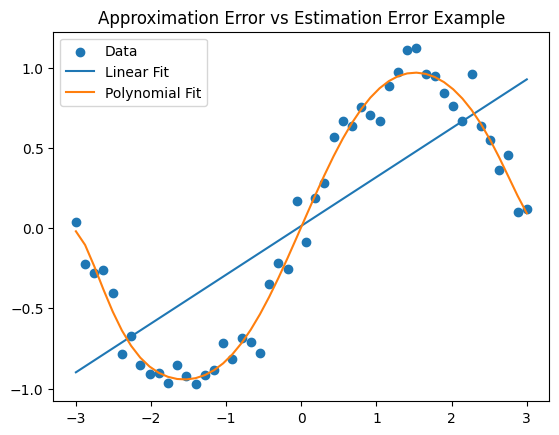

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Generate nonlinear data
np.random.seed(0)
X = np.linspace(-3, 3, 50).reshape(-1, 1)
y = np.sin(X) + np.random.normal(0, 0.1, X.shape)

# Linear fit (high approx. error, low est. error)
lin = LinearRegression().fit(X, y)
y_lin = lin.predict(X)

# Polynomial fit (low approx. error, higher est. error risk)
poly = PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(X)
lin_poly = LinearRegression().fit(X_poly, y)
y_poly = lin_poly.predict(X_poly)

plt.scatter(X, y, label="Data")
plt.plot(X, y_lin, label="Linear Fit")
plt.plot(X, y_poly, label="Polynomial Fit")
plt.legend()
plt.title("Approximation Error vs Estimation Error Example")
plt.show()


### Exercise 1
- Fit polynomial models of degree 2, 5, and 15 to the same data.  
- Compare their training error and test error (use a held-out test set).  
- Which models show more approximation error? Which show more estimation error?


In [6]:
# Your code here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
sort_axis = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sort_axis]
y_test_sorted = y_test[sort_axis]
degrees = [2, 5, 15]
train_errors = {}
test_errors = {}
models = {}
for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)

    lin = LinearRegression().fit(X_poly_train, y_train)
    models[degree] = (lin, poly)
    y_train_pred = lin.predict(X_poly_train)
    y_test_pred = lin.predict(X_poly_test)

    train_errors[degree] = mean_squared_error(y_train, lin.predict(X_poly_train))
    test_errors[degree] = mean_squared_error(y_test_sorted, lin.predict(X_poly_test))

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_errors[degree] = train_mse
    test_errors[degree] = test_mse

    print(f"Degree {degree}:")
    print(f"  Training Error (MSE): {train_mse:.4f}")
    print(f"  Test Error (MSE):     {test_mse:.4f}\n")

Degree 2:
  Training Error (MSE): 0.1931
  Test Error (MSE):     0.2176

Degree 5:
  Training Error (MSE): 0.0116
  Test Error (MSE):     0.0110

Degree 15:
  Training Error (MSE): 0.0076
  Test Error (MSE):     0.0458



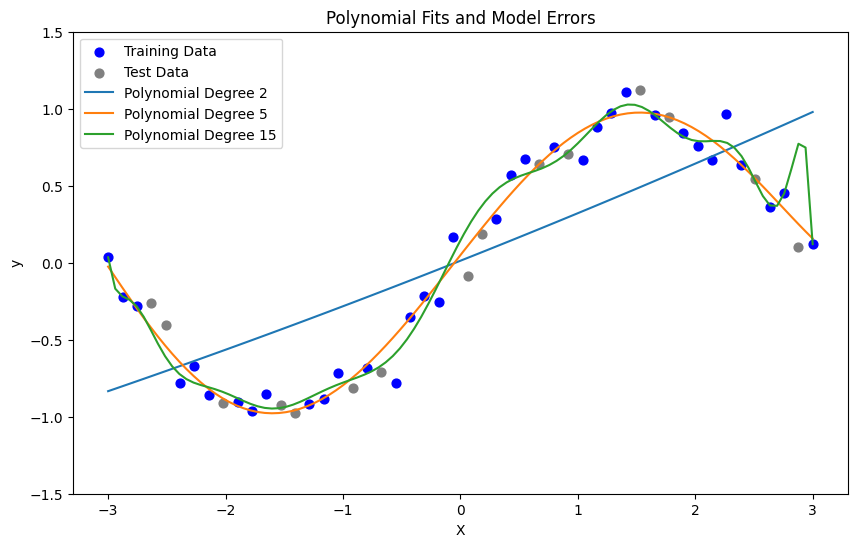

In [13]:

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', s=40, label="Training Data")
plt.scatter(X_test, y_test, color='gray', s=40, label="Test Data")

X_plot = np.linspace(-3, 3, 100).reshape(-1, 1)

for degree in degrees:

    lin, poly = models[degree]
    X_plot_poly = poly.transform(X_plot)
    y_plot = lin.predict(X_plot_poly)
    plt.plot(X_plot, y_plot, label=f"Polynomial Degree {degree}")


plt.legend()
plt.title("Polynomial Fits and Model Errors")
plt.xlabel("X")
plt.ylabel("y")
plt.ylim(-1.5, 1.5)
plt.show()

## 2. Regularized Risk

To reduce overfitting, we add a penalty term to the empirical risk:

$R_{\text{reg}}(h) = R_{\text{emp}}(h) + \lambda \cdot \Omega(h)$

- $R_{\text{emp}}$: training error  
- $\Omega(h)$: complexity of hypothesis (e.g., large weights)  
- $\lambda$: regularization strength  

Examples: **Ridge (L2)**, **Lasso (L1)**.


In [14]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)

ridge = Ridge(alpha=1.0).fit(X_train, y_train)
lasso = Lasso(alpha=0.1, max_iter=10000).fit(X_train, y_train)

print("Ridge test error:", mean_squared_error(y_test, ridge.predict(X_test)))
print("Lasso test error:", mean_squared_error(y_test, lasso.predict(X_test)))


Ridge test error: 0.015494279161805081
Lasso test error: 0.055022128422353586


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-02, tolerance: 1.728e-03
  model = cd_fast.enet_coordinate_descent(


### Exercise 2
Experiment with different values of λ for Ridge regression.  
- How does increasing λ affect training error?  
- How does it affect test error?  
- Why?


Your response here
1. Model with low λ can make training data to fit more closely. if you increase it, makes the model more simple and flexible. this make training error to rise.
2. if λ increases to small value test error decreases, else test error begin to rise.
3. this happens because bias-variance tradeoff. that's why opitmal λ maintains good balance.

## 3. Structural Risk Minimization

ERM chooses the best hypothesis within a model class.  
**Structural Risk Minimization (SRM)** considers a sequence of model classes of increasing complexity, balancing fit and capacity.

- Small models → high approximation error, low estimation error.  
- Large models → low approximation error, high estimation error risk.  

SRM chooses the model class with best **generalization**.


### Exercise 3
Train polynomial regressors with degrees from 1 to 15.  
- Plot training and test error against model degree.  
- Which degree minimizes test error?  
- How does this illustrate SRM?


In [18]:
# Your code here
degrees = np.arange(1, 16)
train_errors = []
test_errors = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)

    model = LinearRegression().fit(X_poly_train, y_train)


    y_train_pred = model.predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

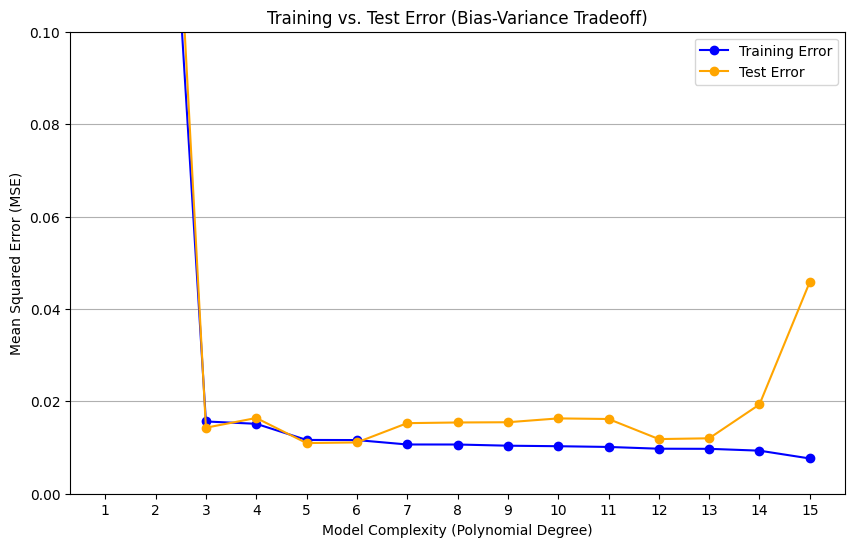

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, 'o-', color='blue', label='Training Error')
plt.plot(degrees, test_errors, 'o-', color='orange', label='Test Error')
plt.xlabel("Model Complexity (Polynomial Degree)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training vs. Test Error (Bias-Variance Tradeoff)")
plt.xticks(degrees)
plt.legend()
plt.grid(axis='y')
plt.ylim(0, 0.1) # Zoom in on the relevant error range
plt.show()

## 4. Cross-Validation

Cross-validation estimates model performance by splitting data into multiple training/test folds.

- **k-fold cross-validation:** split data into k folds, train on k-1, test on 1, rotate.  
- Provides a more stable estimate of generalization error.  


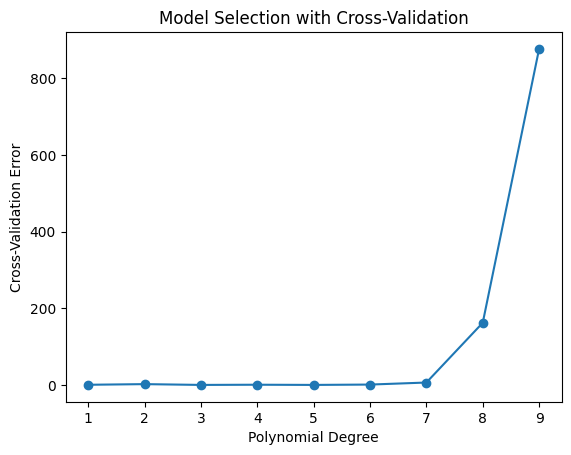

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

degrees = range(1, 10)
cv_scores = []

for d in degrees:
    model = make_pipeline(PolynomialFeatures(d), LinearRegression())
    scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")
    cv_scores.append(-scores.mean())

plt.plot(degrees, cv_scores, marker="o")
plt.xlabel("Polynomial Degree")
plt.ylabel("Cross-Validation Error")
plt.title("Model Selection with Cross-Validation")
plt.show()


### Exercise 4
- Which polynomial degree minimizes cross-validation error?  
- How does this compare to training/test error without cross-validation?  
- Why is cross-validation more reliable?

Your response here
1. at degree 7 we can see the minimum cross-validation error is the same as the one that minimized the error in our previous single train/test split.
2. it is often smoother curve compare to the test curve. this represents average performance.
3. Because it uses all the data both from trained and validation which leads to test each of the data point exactly once. it also gives more stable estimate.





## 5. Reflection

### Exercise 5
Answer in 2–3 sentences each:

1. What is the difference between approximation error and estimation error?  
2. How does regularization reduce overfitting?  
3. Why is cross-validation preferred over a single train/test split?


Your response here
1.  Approximation error is based on bias and estimation error is based on the variance. Simple models have High approximation error, low estimation error.
Complex models have Low approximation error, high estimation error.
2. overfitting occur when model learns traing data too much which include random noises.Regularization prevents this by adding a penalty to the model's loss function. This penalty is proportional to the size of the model's coefficients.
3. there are 2 main reasons to prefer the cross-validation because it can reduces the impact of Randomness and uses data more Efficiently